
**날짜 : 2023/ 03/ 09**

## Brief Intro : Kmeans and GMM Clustering plot

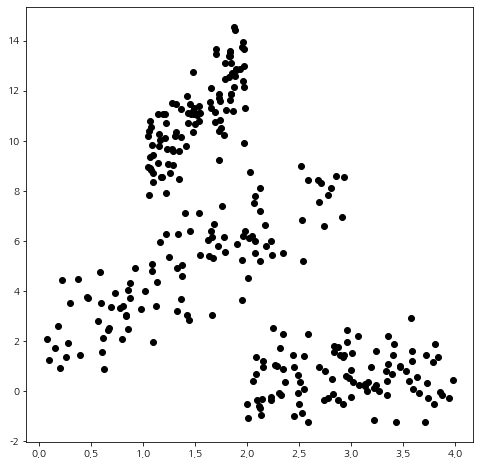

**Clustering by Kmeans** : Euclidian distance를 사용해서 분산구조를 제대로 반영하지 못한다

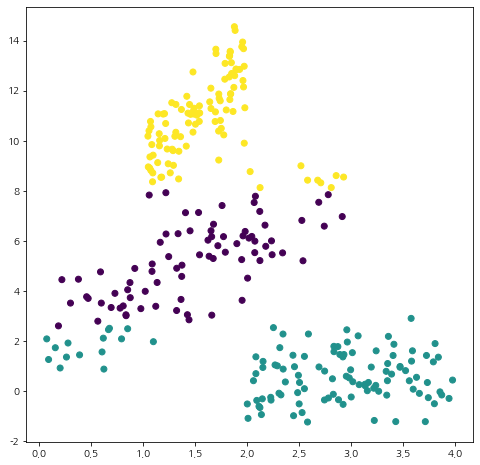

**Clustering by Gaussian Mixture Model**

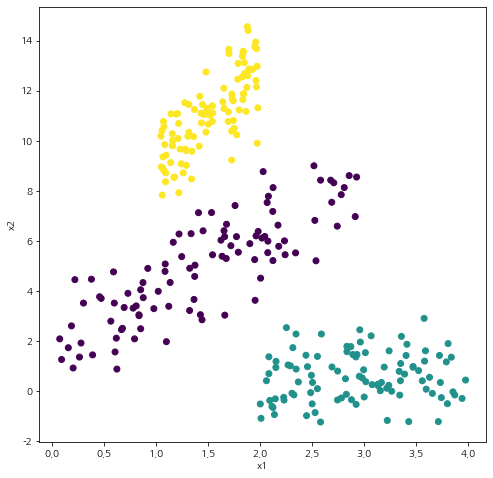

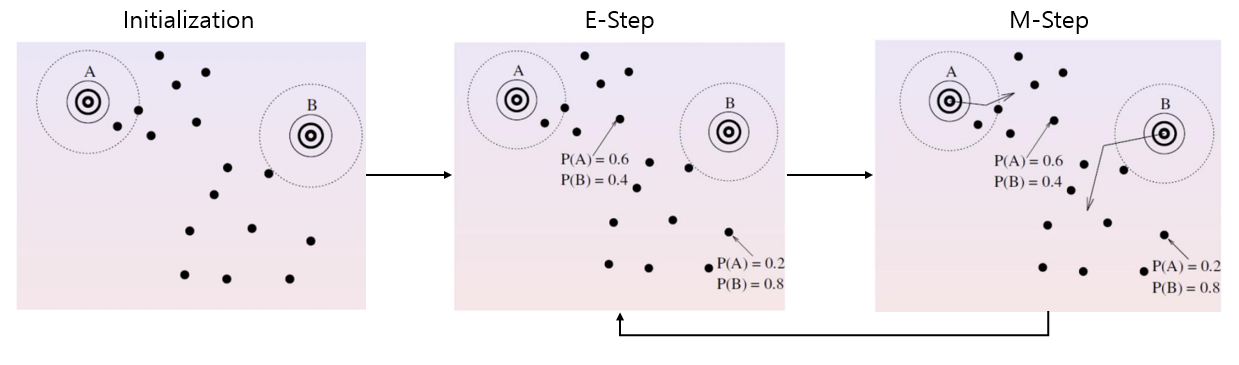

## Scratch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt


In [ ]:
data_unlabeled = pd.read_csv('/content/drive/MyDrive/unlabeled.csv')
x_unlabeled = data_unlabeled[["x1", "x2"]].values

In [ ]:
data_unlabeled.head()

,x1,x2
0,-0.187,0.747
1,2.824,0.377
2,0.713,0.766
3,1.635,1.846
4,2.711,1.996


In [ ]:
x_unlabeled.shape

(1000, 2)

**TASK : cluster each customer to which they will like the product(y=1) or not(y=0).**

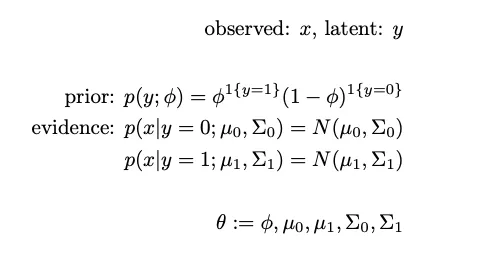

E-step 함수 코드에서 1-pi가 먼저 나오는 이유

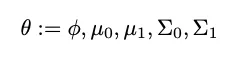

In [ ]:
# 마할라노비스 거리에서 공분산행렬 구할때, 공분산 행렬이 양의 정부호(여기서는 semi) 행렬이 되게 한다.
def get_random_psd(n):
  x = np.random.normal(0,1,size=(n,n))
  return np.dot(x,x.transpose())

# 관심 모수들을 랜덤 초기값으로 세팅한다.
def initialize_random_params():
  params = {'pi' : np.random.uniform(0,1), # selection probabilty of z_ik 
            'mu0' : np.random.normal(0,1,size=(2,)),
            'mu1' : np.random.normal(0,1,size=(2,)),
            'sigma0' : get_random_psd(2),
            'sigma1' : get_random_psd(2)}
  return params

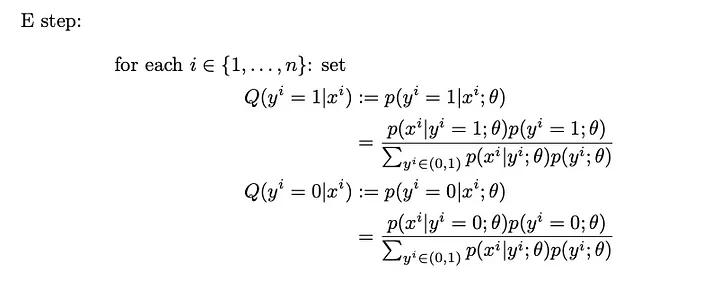

In [ ]:
# E-step : optimize q
# How? By setting q_t(z) = P(X|X,theta_t). Making KL(p||q) = 0 so that both dist. are 'identical'.
def e_step(x, params):
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
          stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]) # likelihood of multivariate normal dist.
  log_p_y_x = np.log([1-params["pi"], params["pi"]])[np.newaxis, ...] + \
              np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
              stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
  log_p_y_x_norm = logsumexp(log_p_y_x, axis=1) # returns log of summed exponentials of inputs. 
  return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis]) # 이부분이 헷갈렸는데, 로그화하면 분모는 빼는 형식으로 변환되기 때문에 뺀 것이다.

# 각 element마다 log likelihood, assignment probability(Q)를 구해줌

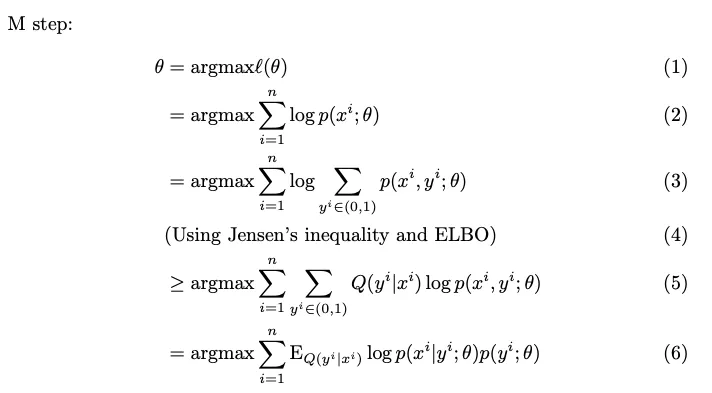

In [ ]:
# M-step : optimize parameter of interest
# How? By setting theta_(t+1) = ARGMAX theta E_qt(z)[ln P(X,Z|theta)]
def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    pi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'pi': pi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

In [ ]:
def get_average_log_likelihood(x,params):
  loglikelihood, _ = e_step(x, params)
  return np.mean(loglikelihood)

def run_em(x,params):
  avg_loglikelihoods = []
  while True:
    avg_loglikelihood = get_average_log_likelihood(x,params)
    avg_loglikelihoods.append(avg_loglikelihood)
    if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001: # setting break according to length of class, and set epsilon error bound.
      break
    params = m_step(x_unlabeled, params)
  print("\tpi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['pi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
  
  _, posterior = e_step(x_unlabeled, params)
  forecasts = np.argmax(posterior, axis=1)
  return forecasts, posterior, avg_loglikelihoods

# posterior는 assignment probability의 최종 version. 교재에서 나온 notation으로 하면 q_inf(z)에 해당하는 부분임
# np.argmax는 Max 값의 인덱스를 반환함. 여기서는 Last E-Step을 거친 assignment probabiltiry가 posterior. 애초에 r(z_ik):assignment probability가 posterior probability이기 때문.

In [ ]:
random_params = initialize_random_params()
unsupervised_forecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(x_unlabeled, random_params)
print("total steps:", len(unsupervised_loglikelihoods))


	pi: 0.997099693619678
	mu_0: [-1.531755    0.67798063]
	mu_1: [0.15152302 0.15801695]
	sigma_0: [[ 0.13182801 -0.01643974]
 [-0.01643974  0.00483802]]
	sigma_1: [[1.56950472 1.21593912]
 [1.21593912 1.48952396]]
total steps: 17


<ipython-input-65-6e0914b6d4d9>:4: RuntimeWarning: divide by zero encountered in log
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
<ipython-input-65-6e0914b6d4d9>:7: RuntimeWarning: divide by zero encountered in log
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),


(step의 Dist.가 매우 random 했다. converge하는 속도가 다른편에 속하는데 유의미한 수준은 아닌듯해서 크게 신경쓰지 않고 넘어감.)

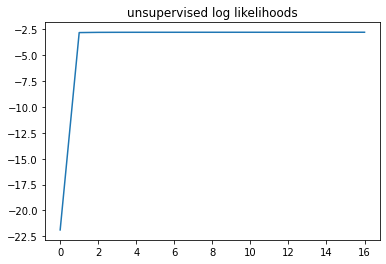

In [ ]:
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.savefig("unsupervised.png")
plt.show()

In [ ]:
unsupervised_posterior[0]

array([1.28252309e-08, 9.99999987e-01])

In [ ]:
unsupervised_forecasts[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Using Scikit-Learn / Compare with labeled dataset 

**저자는 Unsupervised learning의 학습시간의 길이를 단점으로 지적하였다. Unsupervised Learning의 경우 latent factor (pattern)을 찾는데 오랜 시간이 걸리는데, 이는 EM 알고리즘을 사용한 GMM clustering의 단점으로 지적되기도 하는 부분이다.**

**이러한 부분을 저자는, Semi-Supervised Learning을 통해 다소 해결할 수 있다고 주장한다. 이에 대한 근거로는 아래 step의 횟수가 4~5회 인것으로, Unsupervised Learning보다 step의 수가 현저히 적다.**

**이것이 Semi-Supervised Learning의 장점이다. Warm Start를 할 수 있어 학습시간을 단축시킬수 있고, 수렴속도가 빨라진다. 이는 딥러닝에서 lr_scheduling을 통해 구현되기도 하는 부분으로서, epoch가 정해져있는 딥러닝 학습모델에서 loss를 조금 더 minimize할 수 있게 해준다.**

(빠른 수렴속도가 필요한 느린 학습모델같은 경우에 semi-supervised learning이 장점을 지닐것으로 예상했다. 그러나, 수렴속도가 매우 빠른 학습모델의 경우, overfitting의 문제도 생길수 있다는 생각이 들어서, warm start가 무조건적으로 좋다고만은 할수 없는 issue인것 같다.)

In [ ]:
data_labeled = pd.read_csv('/content/drive/MyDrive/labeled.csv')
x_labeled = data_labeled[["x1", "x2"]].values
y_labeled = data_labeled["y"].values

In [ ]:
def learn_params(x_labeled, y_labeled):
    n = x_labeled.shape[0]
    pi = x_labeled[y_labeled == 1].shape[0] / n
    mu0 = np.sum(x_labeled[y_labeled == 0], axis=0) / x_labeled[y_labeled == 0].shape[0]
    mu1 = np.sum(x_labeled[y_labeled == 1], axis=0) / x_labeled[y_labeled == 1].shape[0]
    sigma0 = np.cov(x_labeled[y_labeled == 0].T, bias= True)
    sigma1 = np.cov(x_labeled[y_labeled == 1].T, bias=True)
    return {'pi': pi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}

	pi: 0.5863498817945461
	mu_0: [-1.04546727 -1.02704636]
	mu_1: [0.98763329 0.99661118]
	sigma_0: [[0.36018609 0.30853357]
 [0.30853357 0.75384027]]
	sigma_1: [[0.7196797  0.1437903 ]
 [0.1437903  0.30853791]]
total steps:  4


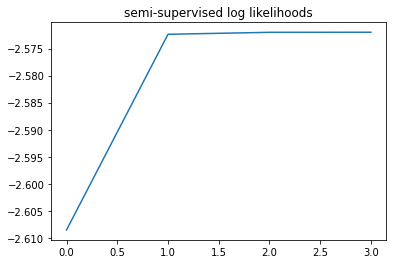

In [ ]:
learned_params = learn_params(x_labeled, y_labeled) # 매우 적은 label data로 random initial parameter를 learned_params로 바꿔줌. 위에서 언급
semisupervised_forecasts, semisupervised_posterior, semisupervised_loglikelihoods = run_em(x_unlabeled, learned_params)
print("total steps: ", len(semisupervised_loglikelihoods))
plt.plot(semisupervised_loglikelihoods)
plt.title("semi-supervised log likelihoods")
plt.savefig("semi-supervised.png")

In [ ]:
def GMM_sklearn(x, weights=None, means=None, covariances=None):
    model = GaussianMixture(n_components=2,
                            covariance_type='full',
                            tol=0.01,
                            max_iter=1000,
                            weights_init=weights,
                            means_init=means,
                            precisions_init=covariances)
    model.fit(x)
    print("\nscikit learn:\n\tpi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (model.weights_[1], model.means_[0, :], model.means_[1, :], model.covariances_[0, :], model.covariances_[1, :]))
    return model.predict(x), model.predict_proba(x)[:,1]
  
  
learned_params = learn_params(x_labeled, y_labeled)
weights = [1 - learned_params["pi"], learned_params["pi"]]
means = [learned_params["mu0"], learned_params["mu1"]]
covariances = [learned_params["sigma0"], learned_params["sigma1"]]
sklearn_forecasts, posterior_sklearn = GMM_sklearn(x_unlabeled, weights, means, covariances)
output_df = pd.DataFrame({'semisupervised_forecasts': semisupervised_forecasts, 
                          'semisupervised_posterior': semisupervised_posterior[:, 1],
                          'sklearn_forecasts': sklearn_forecasts,
                          'posterior_sklearn': posterior_sklearn})
print("\n%s%% of forecasts matched." % (output_df[output_df["semisupervised_forecasts"] == output_df["sklearn_forecasts"]].shape[0] /output_df.shape[0] * 100))


scikit learn:
	pi: 0.5964789422680301
	mu_0: [-1.06169376 -1.0563389 ]
	mu_1: [0.96408565 0.98206315]
	sigma_0: [[0.35027155 0.29629092]
 [0.29629092 0.73083581]]
	sigma_1: [[0.74510804 0.16156928]
 [0.16156928 0.32021029]]

99.4% of forecasts matched.


🍠 Conclusion

 **EM-GMM은 Unsupervised Learning으로 classification하는 목적에도 사용될 수 있다. Unsupervised Learning으로 classification을 하는 방법은 다소 생소하지만 신기하기도 하다.**
 
 **이게 가능한 이유는 multi-nomial dist.를 distribution selection probability로 사용하는 Mixture Model의 컨셉이 결국, assignment probability (r_ik(z)) (posterior) 로 귀결되는 어떤 통계적인 방법론에서 기인하기 때문인듯 함.**

🥔 아쉬운 점

**GMM은 still 군집의 개수인 K 가 사용자 설정임. 이것을 해결하기 위해 Bayesian GMM이 있다는데 Bayesian Nonparametric에 대한 공부가 어느정도 되어있어야 한다고 함. 디리클레 분포랑 해밀턴 MCMC랑 이것저것 적용해야되는 부분이 아직은 생소한 부분이 많기 때문에 일단은 skip.**

**Bayesian Approach의 좋은점**

1. K 개수를 optimize할 수 있음 (어떻게?)

2. 사전지식 반영 가능. mu, sigma, selection probability(pi)에 사전정보 반영 가능. 데이터가 없는 상황에서 더 precise한 성능 가능(군집화, classification, anomaly detection TASK에서)

## Additional Reference

1. https://lee-jaejoon.github.io/BNP-2/ Bayesian Finite Mixture Model

2. https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model?hl=ko Tensorflow Probability 공식 홈페이지. 

    <베이지안 가우시안 혼합 모델 및 해밀턴 MCMC>

## GMM as Density Estimation

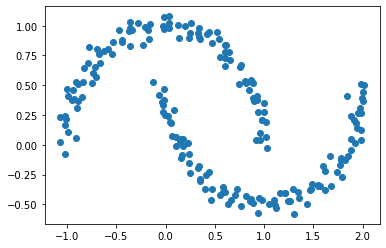

In [ ]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0).fit(Xmoon)

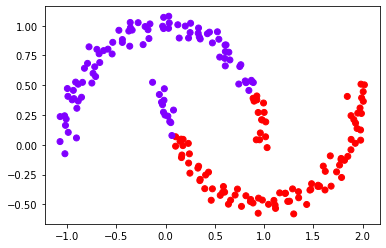

In [ ]:
gmm2_labels = gmm2.predict(Xmoon)
plt.scatter(Xmoon[:,0],Xmoon[:,1],c=gmm2_labels, cmap = 'rainbow')
plt.show()

다변량정규분포처럼 데이터셋이 타원형으로 plot에 그려지는 multi-modal data들에 대해서는 잘 예측할 수 있다. 그러나 위와 같이 특수한 경우에는 군집화가 제대로 이루어지지 않은 것을 볼 수 있다.

이러한 이유는, 이 데이터를 군집화 할때, 분산구조를 고려하는 것 보다, 데이터들의 sequential 한 거리가 적은 것을 하나의 군집으로 고려해야하기 때문이다.

이렇듯 데이터의 형태에 따라 다른 군집화 방법론을 적용시키는 것이 중요함.

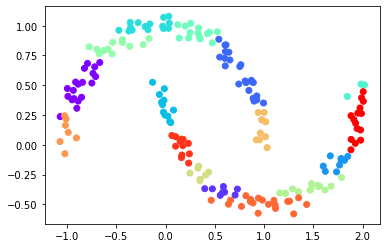

In [ ]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0).fit(Xmoon)
gmm16_labels = gmm16.predict(Xmoon)
plt.scatter(Xmoon[:,0],Xmoon[:,1],c=gmm16_labels, cmap = 'rainbow')
plt.show()

In [ ]:
Xnew = gmm16.sample(400)
pd.DataFrame.from_records(Xnew).transpose().drop(columns=[1],axis=1).head()
# plt.scatter(Xnew[:, 0], Xnew[:, 1])

,0
0,"[-0.9180243437995312, 0.4264852993499426]"
1,"[-0.7911479471556516, 0.7019832612276611]"
2,"[-1.0208538892585495, 0.22850745293935987]"
3,"[-0.8498637019168785, 0.4631601490657908]"
4,"[-0.7587088776364969, 0.6790701421598866]"
